In [1]:
#importing neccesary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load images and captions data

In [4]:
image_path = '/content/drive/MyDrive/BASE_DIR/Images'

In [5]:
data = pd.read_csv("/content/drive/MyDrive/BASE_DIR/cleaned_captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Show some sample images with captions

In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/BASE_DIR/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

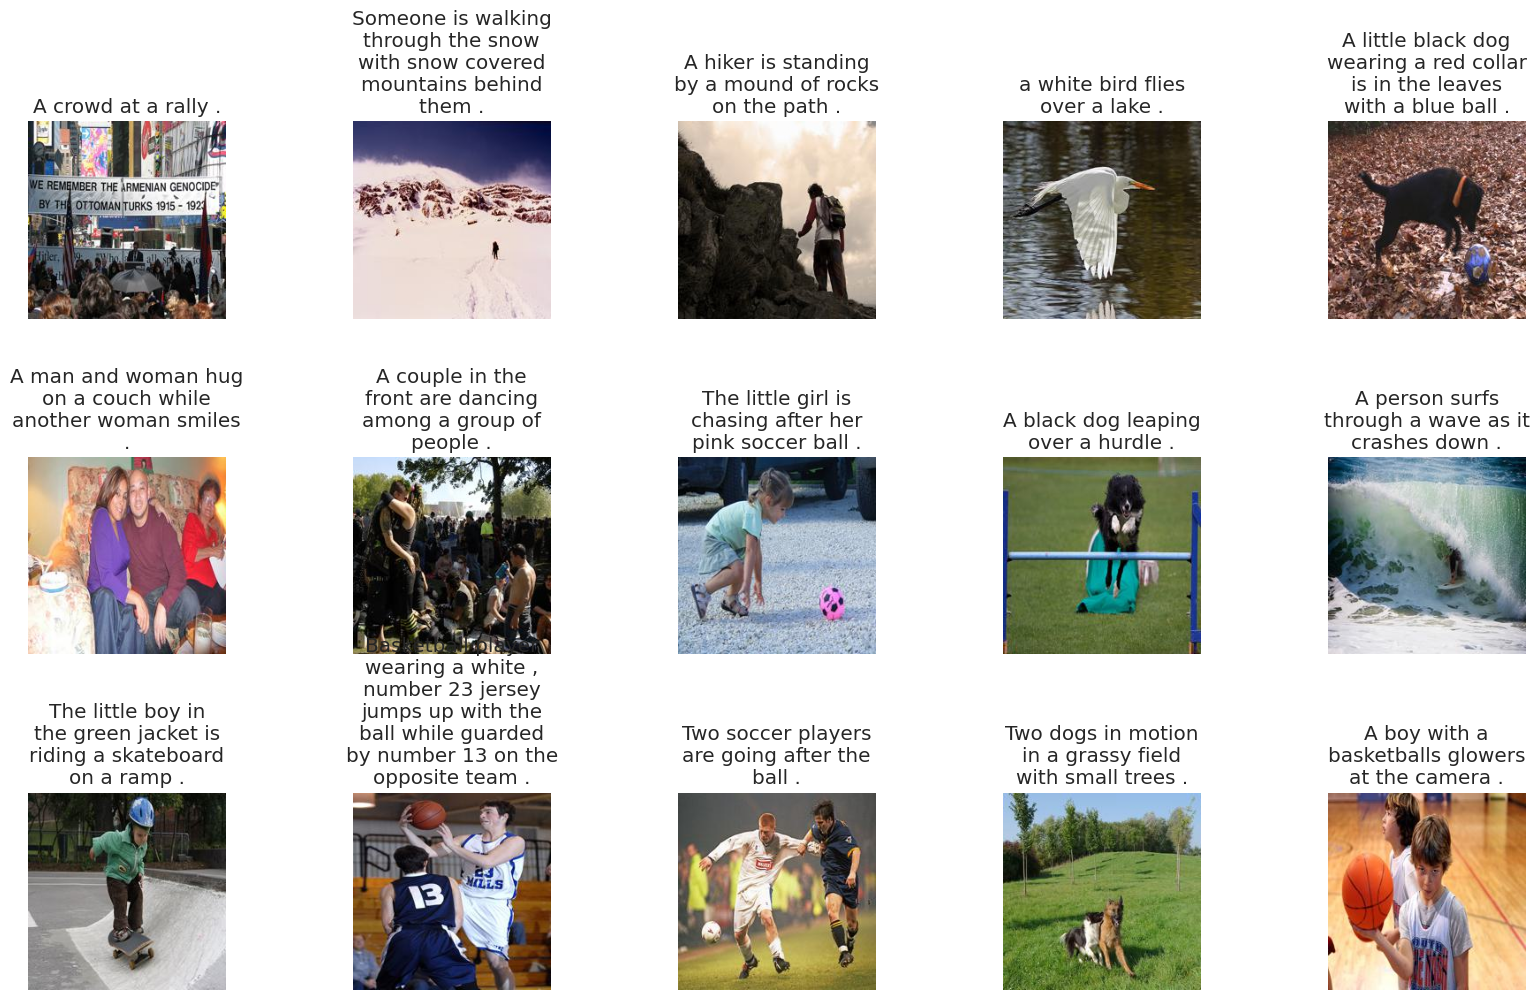

In [ ]:
display_images(data.sample(15))

# Captions Text data preprocessing and build tokenizer

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [8]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [9]:
#Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [ ]:
import pickle

tokenizer_path = '/content/drive/MyDrive/WORKING_DIR/tokenizer_c3.pkl'

# Save the tokenizer to a .pkl file
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved to {tokenizer_path}")


Tokenizer saved to /content/drive/MyDrive/WORKING_DIR/tokenizer_c3.pkl


# Build Custom Cnn for feature extraction from images

In [ ]:
#Cnn model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D

def build_custom_cnn(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)

    model = Model(inputs, x)
    return model


In [ ]:

custom_cnn = build_custom_cnn()
img_size = 224

# Load and preprocess each image
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Get features from your CNN
    feature = custom_cnn.predict(img, verbose=0)
    features[image] = feature[0]

In [ ]:
# Save features to the specified location

import pickle
import os


output_dir = '/content/drive/MyDrive/WORKING_DIR'

output_file = os.path.join(output_dir, 'features_cnn2.pkl')

with open(output_file, 'wb') as f:
    pickle.dump(features, f)


In [ ]:
# Load features from the saved pickle file
import pickle
import os

input_file = '/content/drive/MyDrive/WORKING_DIR/features_cnn2.pkl'

with open(input_file, 'rb') as f:
    features = pickle.load(f)

print("Features loaded successfully")


Features loaded successfully


**Data generator**

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image]


            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# Build Lstm model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, concatenate,
    Reshape, Bidirectional, BatchNormalization, add, Dense
)

# Inputs
input1 = Input(shape=(256,))  # Image feature from your custom CNN
input2 = Input(shape=(max_length,))  # Partial caption

# Caption embedding
sentence_features = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False)(input2)

# Reshape image to match LSTM input format (as 1 time step)
img_features_reshaped = Reshape((1, 256))(input1)

# Concatenate image as first time step
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# Bidirectional LSTM with 128 units (output = 256 dims total)
sentence_features = Bidirectional(LSTM(128))(merged)  # Output shape = (256,)

# Dropout + batch norm
x = Dropout(0.5)(sentence_features)
x = BatchNormalization()(x)

# Add skip connection with original image feature
x = add([x, input1])

# Dense transformation
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# Final prediction
output = Dense(vocab_size, activation='softmax')(x)

# Build and compile model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


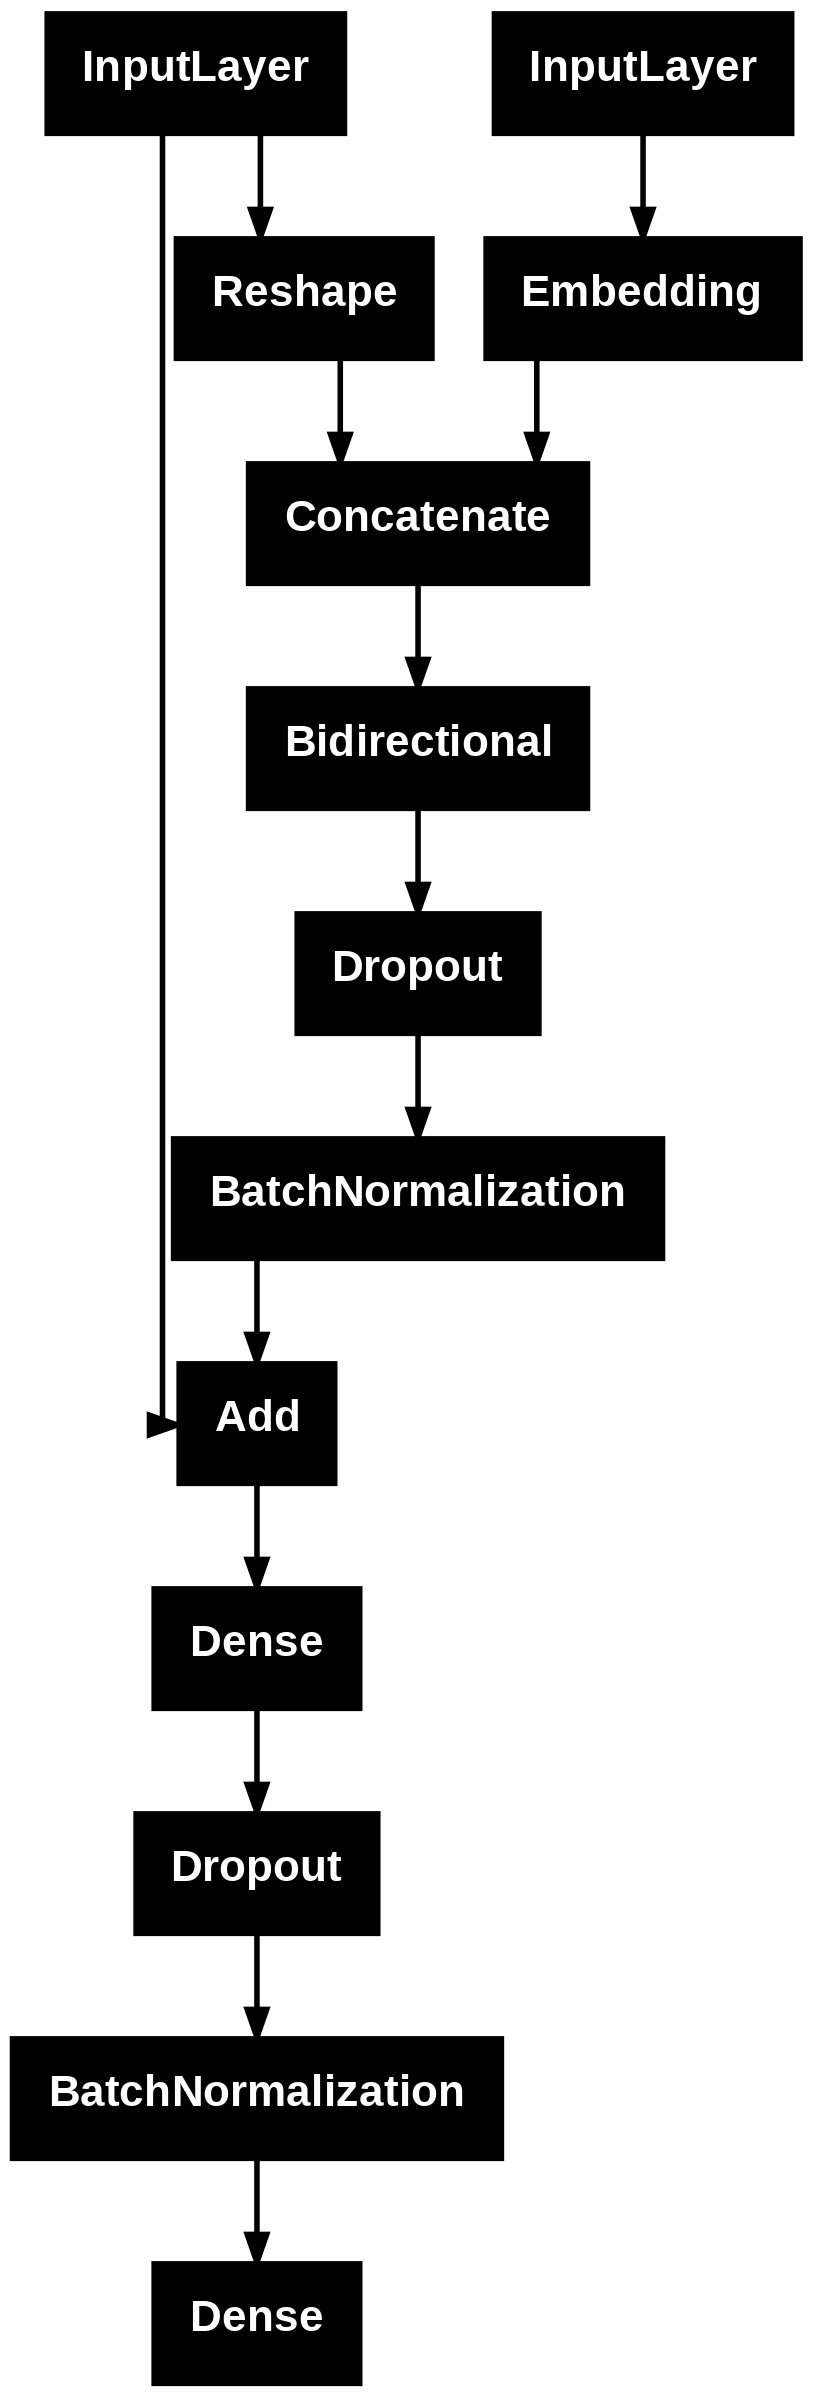

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

# Train the Image caption model with k fold cross validation

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Set the number of folds (k)
k = 4

# Initialize KFold with shuffle=True to randomize the splits
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Capture loss and accuracy for each fold
fold_losses = []
fold_accuracies = []


In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(images)):
    print(f"Training fold {fold + 1}/{k}")

    # Use the indices to select the images for this fold
    train_images = np.array(images)[train_idx]
    val_images = np.array(images)[val_idx]

    # Filter your train and validation data
    train_fold = train[train['image'].isin(train_images)]
    val_fold = train[train['image'].isin(val_images)]

    # Create data generators for this fold
    train_generator = CustomDataGenerator(df=train_fold, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                          tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

    validation_generator = CustomDataGenerator(df=val_fold, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                               tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

    # Define callbacks
    model_name = f"model_ic_fold{fold + 1}.h5"
    checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

    # Train the model on this fold and capture the history (loss, accuracy)
    history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]
    )

    # Append fold loss and accuracy to the lists
    fold_losses.append(history.history['loss'])
    fold_accuracies.append(history.history['accuracy'])


Training fold 1/4
Epoch 1/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2920 - loss: 3.6991
Epoch 1: val_loss improved from inf to 3.36308, saving model to model_ic_fold1.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 113s 279ms/step - accuracy: 0.2920 - loss: 3.6992 - val_accuracy: 0.3193 - val_loss: 3.3631 - learning_rate: 0.0010
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2947 - loss: 3.6418
Epoch 2: val_loss did not improve from 3.36308
403/403 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.2946 - loss: 3.6419 - val_accuracy: 0.3167 - val_loss: 3.4100 - learning_rate: 0.0010
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2979 - loss: 3.5962
Epoch 3: val_loss did not improve from 3.36308
403/403 ━━━━━━━━━━━━━━━━━━━━ 118s 293ms/step - accuracy: 0.2979 - loss: 3.5963 - val_accuracy: 0.3153 - val_loss: 3.4226 - learning_rate: 0.0010
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2971 - loss: 3.5772
Epoch 4: val_loss did not improve from 3.36308

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
403/403 ━━━━━━━━━━━━━━━━━━━━ 90s 224ms/step - accuracy: 0.2971 - loss: 3.5773 - val

401/401 ━━━━━━━━━━━━━━━━━━━━ 90s 225ms/step - accuracy: 0.2972 - loss: 3.6141 - val_accuracy: 0.3228 - val_loss: 3.3358 - learning_rate: 2.0000e-04
Epoch 2/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.3015 - loss: 3.5715
Epoch 2: val_loss did not improve from 3.33585
401/401 ━━━━━━━━━━━━━━━━━━━━ 108s 270ms/step - accuracy: 0.3015 - loss: 3.5716 - val_accuracy: 0.3236 - val_loss: 3.3390 - learning_rate: 2.0000e-04
Epoch 3/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3002 - loss: 3.5724
Epoch 3: val_loss did not improve from 3.33585
401/401 ━━━━━━━━━━━━━━━━━━━━ 121s 302ms/step - accuracy: 0.3002 - loss: 3.5724 - val_accuracy: 0.3220 - val_loss: 3.3465 - learning_rate: 2.0000e-04
Epoch 4/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.3017 - loss: 3.5541
Epoch 4: val_loss did not improve from 3.33585

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
401/401 ━━━━━━━━━━━━━━━━━━━━ 111s 277ms/step - accuracy: 0.3017 - loss:

403/403 ━━━━━━━━━━━━━━━━━━━━ 94s 233ms/step - accuracy: 0.2942 - loss: 3.6407 - val_accuracy: 0.3367 - val_loss: 3.1771 - learning_rate: 4.0000e-05
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2955 - loss: 3.6352
Epoch 2: val_loss did not improve from 3.17713
403/403 ━━━━━━━━━━━━━━━━━━━━ 88s 220ms/step - accuracy: 0.2955 - loss: 3.6352 - val_accuracy: 0.3362 - val_loss: 3.1810 - learning_rate: 4.0000e-05
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2975 - loss: 3.6148
Epoch 3: val_loss did not improve from 3.17713
403/403 ━━━━━━━━━━━━━━━━━━━━ 103s 256ms/step - accuracy: 0.2975 - loss: 3.6148 - val_accuracy: 0.3362 - val_loss: 3.1806 - learning_rate: 4.0000e-05
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.2978 - loss: 3.6134
Epoch 4: val_loss did not improve from 3.17713

Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
403/403 ━━━━━━━━━━━━━━━━━━━━ 132s 232ms/step - accuracy: 0.2978 - loss: 3

403/403 ━━━━━━━━━━━━━━━━━━━━ 97s 240ms/step - accuracy: 0.2994 - loss: 3.5746 - val_accuracy: 0.3274 - val_loss: 3.3228 - learning_rate: 8.0000e-06
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2984 - loss: 3.5809
Epoch 2: val_loss did not improve from 3.32279
403/403 ━━━━━━━━━━━━━━━━━━━━ 94s 233ms/step - accuracy: 0.2984 - loss: 3.5809 - val_accuracy: 0.3271 - val_loss: 3.3250 - learning_rate: 8.0000e-06
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2988 - loss: 3.5760
Epoch 3: val_loss did not improve from 3.32279
403/403 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.2988 - loss: 3.5761 - val_accuracy: 0.3272 - val_loss: 3.3243 - learning_rate: 8.0000e-06
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2988 - loss: 3.5778
Epoch 4: val_loss did not improve from 3.32279

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
403/403 ━━━━━━━━━━━━━━━━━━━━ 96s 238ms/step - accuracy: 0.2988 - loss: 3.

# Plot loss per epoch graph

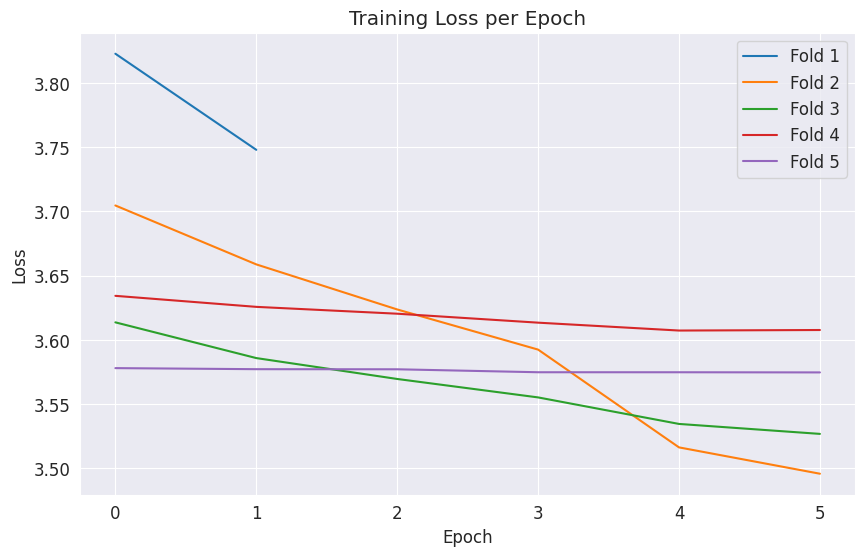

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, loss in enumerate(fold_losses):
    plt.plot(loss, label=f'Fold {i+1}')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot accuracy per epoch graph

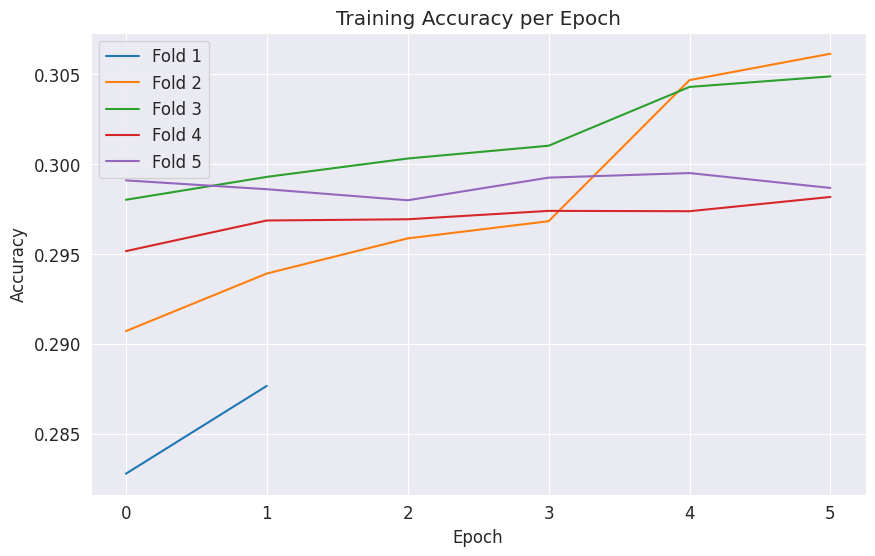

In [ ]:
plt.figure(figsize=(10, 6))
for i, acc in enumerate(fold_accuracies):
    plt.plot(acc, label=f'Fold {i+1}')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Predict caption for images by our trained model

In [ ]:
# Returns the word corresponding to a given integer index from the tokenizer
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
#predict caption model
def predict_caption(model, image, tokenizer, max_length, features):

    feature = np.expand_dims(features[image], axis=0)
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text


# Plot 15 sample images with predicted caption

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

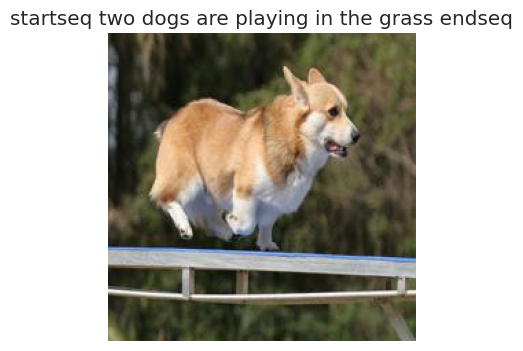

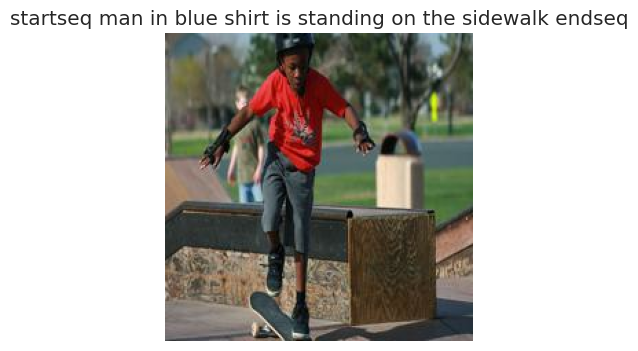

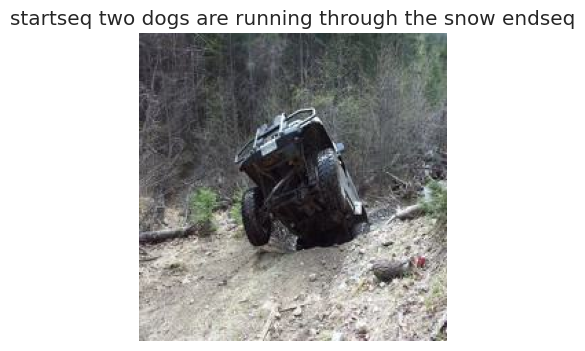

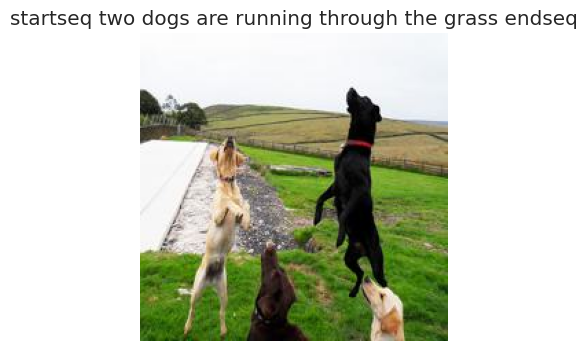

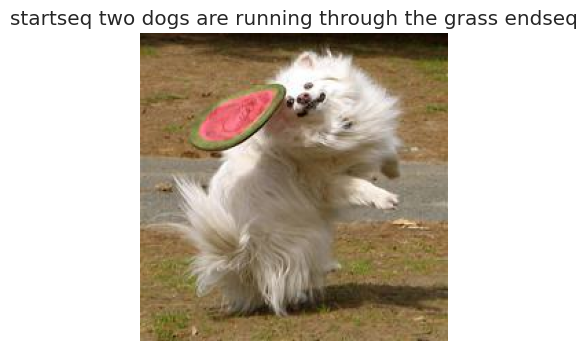

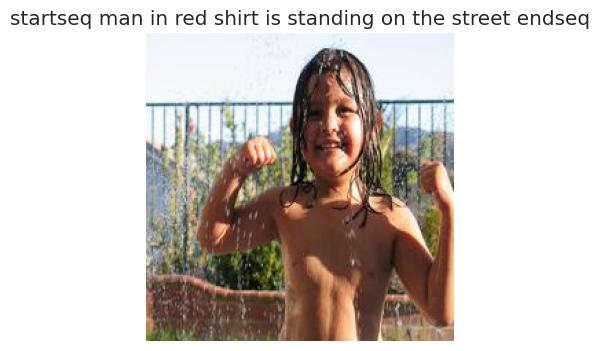

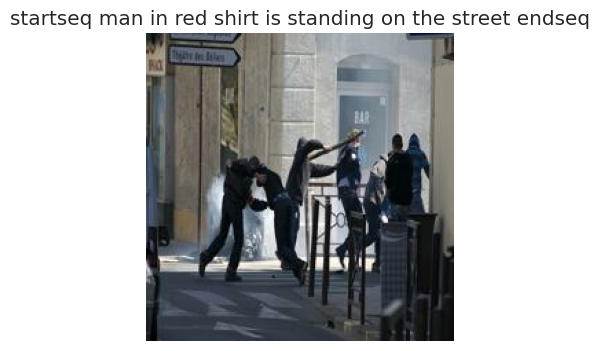

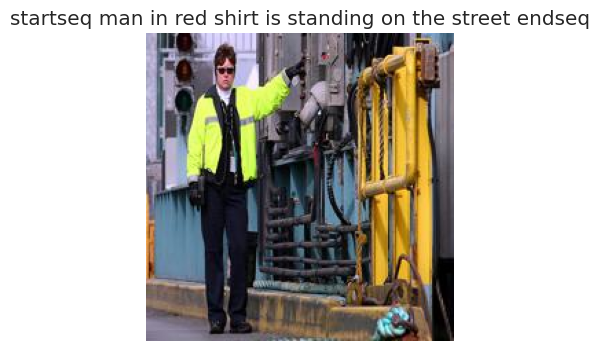

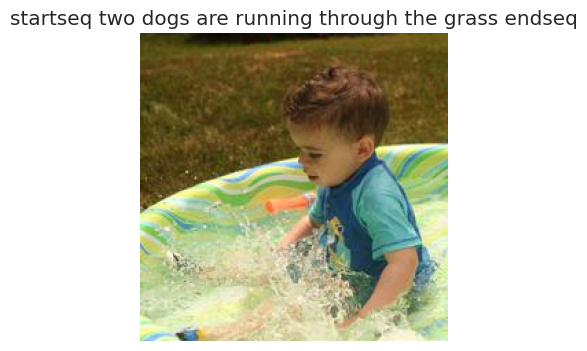

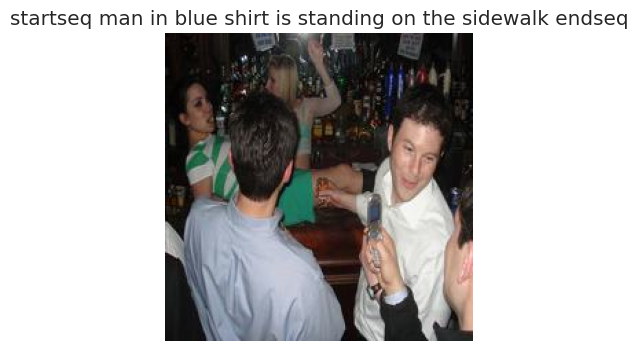

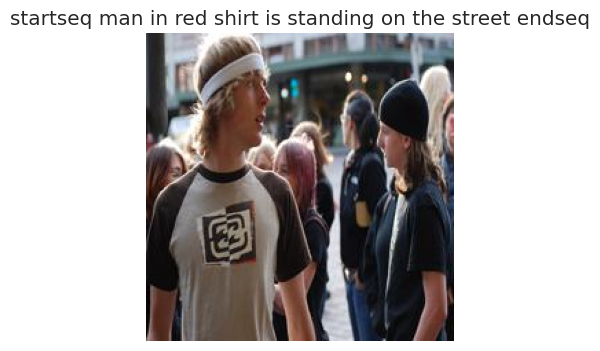

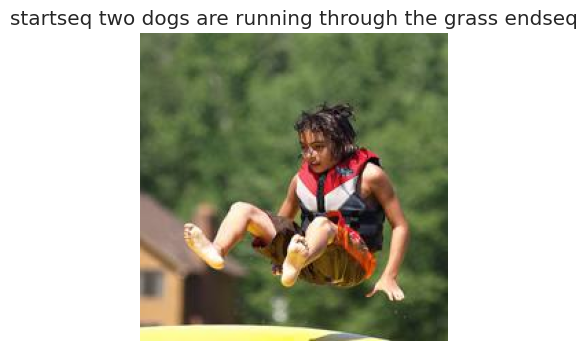

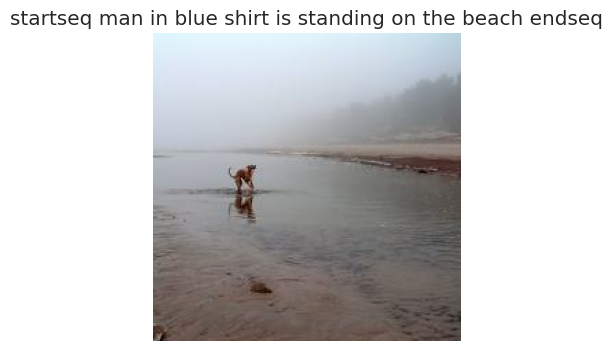

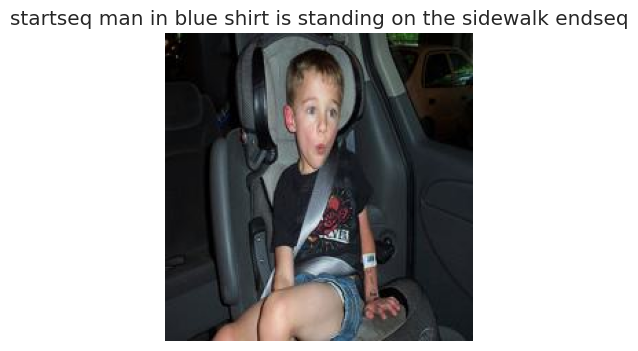

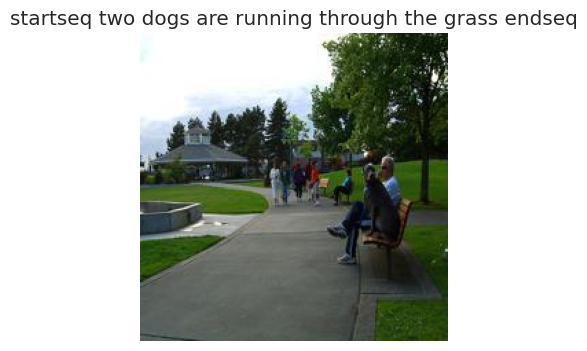

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

for i in range(len(samples)):
    image_file = samples.loc[i, 'image']
    caption = samples.loc[i, 'caption']

    # Load image
    img_path = os.path.join(image_path, image_file)
    img = load_img(img_path, target_size=(224, 224))

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()


# calculate BLEU score - Evaluation metric

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu_score(test_df, tokenizer, model, features, max_length):
    references = []
    predictions = []

    for index, record in test_df.iterrows():
        # Predict the caption for the image
        image = record['image']
        predicted_caption = predict_caption(model, image, tokenizer, max_length, features)

        # Get the ground truth captions (all captions for that image)
        ground_truth_captions = record['caption'].split(" endseq")[0].replace("startseq", "").strip().split()

        # Add reference (ground truth) and prediction to the lists
        references.append([ground_truth_captions])
        predictions.append(predicted_caption.split())


    smoothing_function = SmoothingFunction().method4
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothing_function)

    return bleu_score

# Compute BLEU score for the test set
bleu = compute_bleu_score(samples, tokenizer, caption_model, features, max_length)
print(f'BLEU score: {bleu:.4f}')


BLEU score: 0.7618


# Predict caption for new image

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict next word
        yhat = model.predict([features, sequence], verbose=0)
        yhat = np.argmax(yhat)

        # Convert predicted index to word
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break

        # Append word to the input text
        in_text += ' ' + word

        if word == 'endseq':
            break

    return in_text.split(' ')[1:-1]  # remove 'startseq' and 'endseq'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


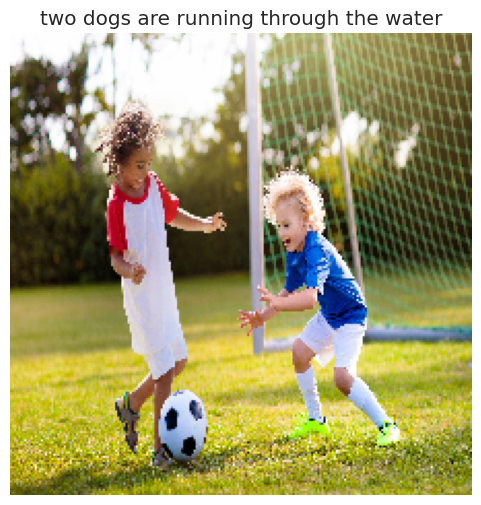

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def generate_caption_for_new_image(image_path, model, tokenizer, max_length, cnn_model):
    #Load and preprocess the new image (resize to 224x224)
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)

    # Extract features using custom CNN
    image_features = cnn_model.predict(img)

    #  Generate the caption
    caption = predict_caption(model, image_path, tokenizer, max_length, image_features)

    # Display the image and caption
    plt.figure(figsize=(6, 6))
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(' '.join(caption))
    plt.show()

# Example usage:
image_path = '/content/bigstock-Kids-Play-Football-Cute-Littl-471646067.jpg'
generate_caption_for_new_image(image_path, caption_model, tokenizer, max_length, custom_cnn)
